# SVR

## Selecting the appropriate Kernel.   

Kernel:  25%|██▌       | 1/4 [00:11<00:33, 11.01s/kernel]

Linear Kernel:
  Average Mean Squared Error (Original Scale) = 1.7950
  Average Mean Squared Error (Normalized Scale) = 0.0211


Kernel:  50%|█████     | 2/4 [00:18<00:17,  8.80s/kernel]

RBF Kernel:
  Average Mean Squared Error (Original Scale) = 1.0002
  Average Mean Squared Error (Normalized Scale) = 0.0118


Kernel:  75%|███████▌  | 3/4 [04:53<02:10, 130.39s/kernel]

Polynomial Kernel:
  Average Mean Squared Error (Original Scale) = 1.7409
  Average Mean Squared Error (Normalized Scale) = 0.0205


Kernel: 100%|██████████| 4/4 [05:16<00:00, 79.20s/kernel] 


Sigmoid Kernel:
  Average Mean Squared Error (Original Scale) = 398280.0463
  Average Mean Squared Error (Normalized Scale) = 4691.7785


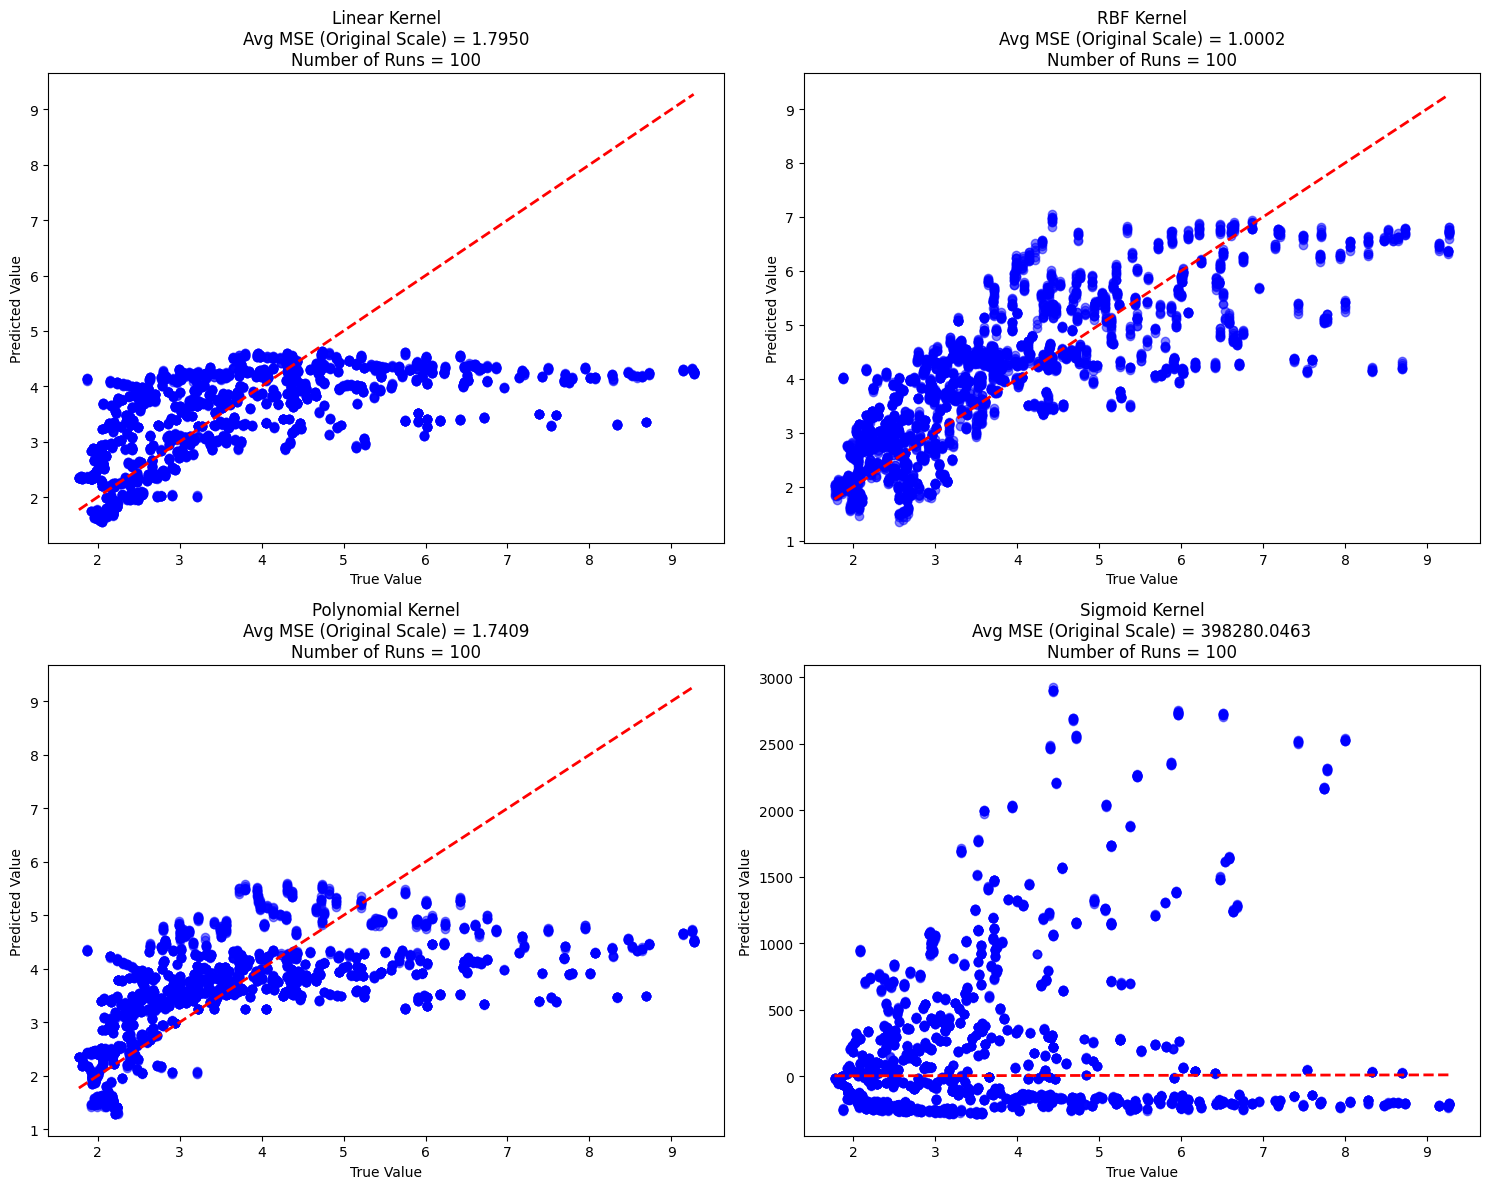

In [2]:
import geopandas as gpd
from sklearn.preprocessing import MinMaxScaler
from sklearn.svm import SVR
from sklearn.metrics import mean_squared_error
import matplotlib.pyplot as plt
import numpy as np
from tqdm import tqdm

plt.figure(figsize=(15, 12))

# Load your shapefile into a GeoDataFrame
gdf = gpd.read_file('UK_PPT_DEM_12km.shp')

# Extract features and target variable
features = gdf[['latitude', 'longitude']]
target = gdf['value']

# Initialize scalers
feature_scaler = MinMaxScaler()
target_scaler = MinMaxScaler()

# Fit scalers and transform the data
scaled_features = feature_scaler.fit_transform(features)
scaled_target = target_scaler.fit_transform(target.to_numpy().reshape(-1, 1)).ravel()

# Append scaled columns to the original GeoDataFrame
gdf['norm_lat'] = scaled_features[:, 0]
gdf['norm_long'] = scaled_features[:, 1]
gdf['norm_val'] = scaled_target

# Separate coastal points
coastal_points = gdf[gdf['classifica'] == 'coastal']

# Number of runs and range for random state
num_runs = 100
random_states = np.random.randint(0, 100000, num_runs)

# Define kernels to test
kernels = ['linear', 'rbf', 'poly', 'sigmoid']
kernel_labels = ['Linear', 'RBF', 'Polynomial', 'Sigmoid']

# Initialize dictionaries to store results
mse_results = {kernel: [] for kernel in kernels}
mse_results_normalized = {kernel: [] for kernel in kernels}
all_test = {kernel: [] for kernel in kernels}
all_pred = {kernel: [] for kernel in kernels}

# Loop through each kernel with tqdm
for kernel in tqdm(kernels, desc='Kernel', unit='kernel'):
    kernel_mse = []
    kernel_mse_normalized = []
    for random_state in tqdm(random_states, desc=f'{kernel_labels[kernels.index(kernel)]} Kernel', unit='run'):
        # Determine the number of coastal points to be used for testing
        num_coastal_test = int(len(coastal_points) * 0.10)

        # Randomly select 10% of the coastal points for testing
        coastal_test_indices = coastal_points.sample(n=num_coastal_test, random_state=random_state).index

        # Create the test set by selecting the rows with the chosen indices
        test_data = gdf.loc[coastal_test_indices]

        # Create the training dataset by dropping the selected coastal points
        training_data = gdf.drop(coastal_test_indices)

        # Extract features and target variables from the training and test datasets
        X_train = training_data[['norm_lat', 'norm_long']].values
        y_train = training_data['norm_val'].values
        X_test = test_data[['norm_lat', 'norm_long']].values
        y_test = test_data['norm_val'].values

        # Initialize SVR with the kernel
        svr = SVR(kernel=kernel)
        
        # Fit the model
        svr.fit(X_train, y_train)
        
        # Predict on the test data
        y_pred = svr.predict(X_test)
        
        # Inverse transform predictions and true values to original scale
        y_test_orig = target_scaler.inverse_transform(y_test.reshape(-1, 1))
        y_pred_orig = target_scaler.inverse_transform(y_pred.reshape(-1, 1))
        
        # Append to all_test and all_pred
        all_test[kernel].append(y_test_orig.ravel())
        all_pred[kernel].append(y_pred_orig.ravel())
        
        # Calculate performance
        mse_normalized = mean_squared_error(y_test, y_pred)  # MSE on normalized values
        mse_original = mean_squared_error(y_test_orig, y_pred_orig)  # MSE on original values
        
        kernel_mse.append(mse_original)
        kernel_mse_normalized.append(mse_normalized)

    # Flatten lists and convert to numpy arrays
    all_test[kernel] = np.concatenate(all_test[kernel])
    all_pred[kernel] = np.concatenate(all_pred[kernel])

    # Average MSE over all runs
    avg_mse_original = np.mean(kernel_mse)
    avg_mse_normalized = np.mean(kernel_mse_normalized)
    
    # Store results
    mse_results[kernel].append(avg_mse_original)
    mse_results_normalized[kernel].append(avg_mse_normalized)
    
    # Print average MSE
    print(f'{kernel_labels[kernels.index(kernel)]} Kernel:')
    print(f'  Average Mean Squared Error (Original Scale) = {avg_mse_original:.4f}')
    print(f'  Average Mean Squared Error (Normalized Scale) = {avg_mse_normalized:.4f}')
    
    # Plot True vs. Predicted for this kernel
    plt.subplot(2, 2, kernels.index(kernel) + 1)  # 2x2 grid
    plt.scatter(all_test[kernel], all_pred[kernel], alpha=0.5, color='blue')
    plt.plot([all_test[kernel].min(), all_test[kernel].max()], [all_test[kernel].min(), all_test[kernel].max()], 'r--', lw=2)  # Line for perfect fit
    plt.xlabel('True Value')
    plt.ylabel('Predicted Value')
    plt.title(f'{kernel_labels[kernels.index(kernel)]} Kernel\nAvg MSE (Original Scale) = {avg_mse_original:.4f}\nNumber of Runs = {num_runs}')

plt.tight_layout()
plt.show()


Kernel:  25%|██▌       | 1/4 [00:08<00:26,  8.87s/kernel]

Linear Kernel:
  Average Mean Squared Error (Original Scale) = 1.5394
  Average Mean Squared Error (Normalized Scale) = 0.0181


Kernel:  50%|█████     | 2/4 [00:18<00:18,  9.03s/kernel]

RBF Kernel:
  Average Mean Squared Error (Original Scale) = 0.9416
  Average Mean Squared Error (Normalized Scale) = 0.0111


Kernel:  75%|███████▌  | 3/4 [01:46<00:45, 45.47s/kernel]

Polynomial Kernel:
  Average Mean Squared Error (Original Scale) = 1.4250
  Average Mean Squared Error (Normalized Scale) = 0.0168


Kernel: 100%|██████████| 4/4 [02:09<00:00, 32.47s/kernel]


Sigmoid Kernel:
  Average Mean Squared Error (Original Scale) = 444099.9178
  Average Mean Squared Error (Normalized Scale) = 5231.5412


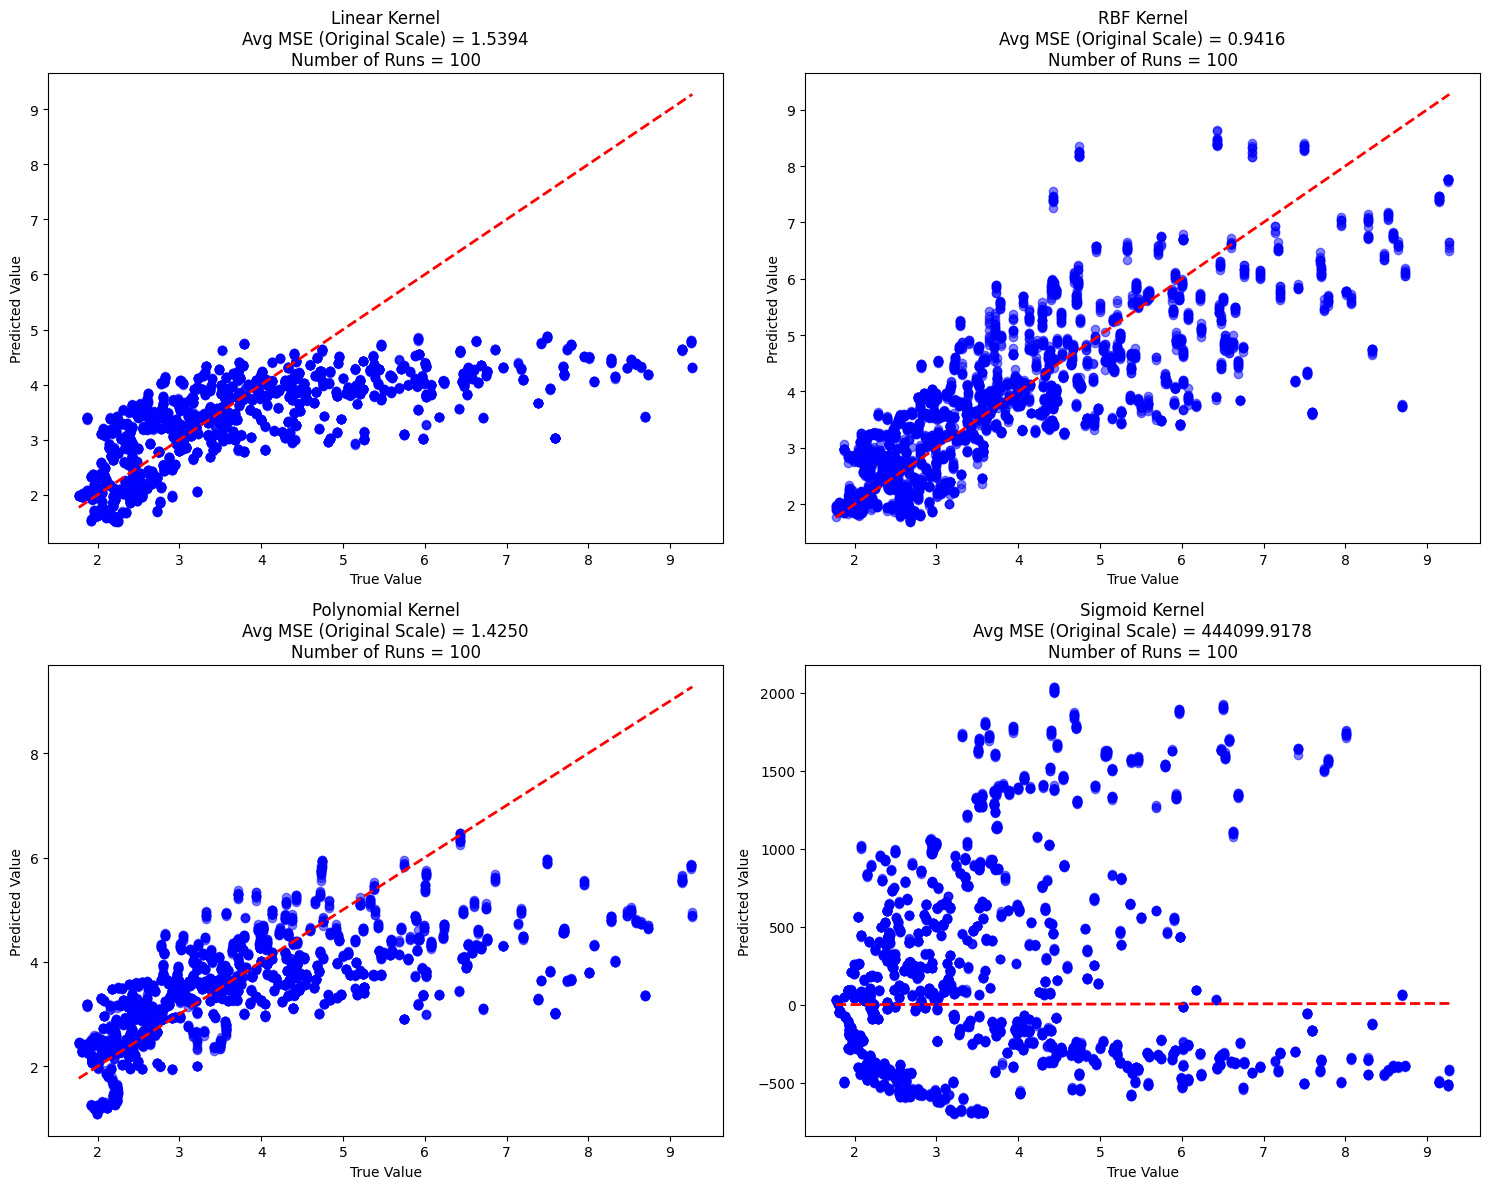

In [3]:
import geopandas as gpd
from sklearn.preprocessing import MinMaxScaler
from sklearn.svm import SVR
from sklearn.metrics import mean_squared_error
import matplotlib.pyplot as plt
import numpy as np
from tqdm import tqdm

plt.figure(figsize=(15, 12))

# Load your shapefile into a GeoDataFrame
gdf = gpd.read_file('UK_PPT_DEM_12km.shp')

# Extract features and target variable
features = gdf[['latitude', 'longitude', 'average_de']]  # Added 'elevation'
target = gdf['value']

# Initialize scalers
feature_scaler = MinMaxScaler()
target_scaler = MinMaxScaler()

# Fit scalers and transform the data
scaled_features = feature_scaler.fit_transform(features)
scaled_target = target_scaler.fit_transform(target.to_numpy().reshape(-1, 1)).ravel()

# Append scaled columns to the original GeoDataFrame
gdf['norm_lat'] = scaled_features[:, 0]
gdf['norm_long'] = scaled_features[:, 1]
gdf['norm_elev'] = scaled_features[:, 2]  # Added normalized elevation
gdf['norm_val'] = scaled_target

# Separate coastal points
coastal_points = gdf[gdf['classifica'] == 'coastal']

# Number of runs and range for random state
num_runs = 100
random_states = np.random.randint(0, 100000, num_runs)

# Define kernels to test
kernels = ['linear', 'rbf', 'poly', 'sigmoid']
kernel_labels = ['Linear', 'RBF', 'Polynomial', 'Sigmoid']

# Initialize dictionaries to store results
mse_results = {kernel: [] for kernel in kernels}
mse_results_normalized = {kernel: [] for kernel in kernels}
all_test = {kernel: [] for kernel in kernels}
all_pred = {kernel: [] for kernel in kernels}

# Loop through each kernel with tqdm
for kernel in tqdm(kernels, desc='Kernel', unit='kernel'):
    kernel_mse = []
    kernel_mse_normalized = []
    for random_state in tqdm(random_states, desc=f'{kernel_labels[kernels.index(kernel)]} Kernel', unit='run'):
        # Determine the number of coastal points to be used for testing
        num_coastal_test = int(len(coastal_points) * 0.10)

        # Randomly select 10% of the coastal points for testing
        coastal_test_indices = coastal_points.sample(n=num_coastal_test, random_state=random_state).index

        # Create the test set by selecting the rows with the chosen indices
        test_data = gdf.loc[coastal_test_indices]

        # Create the training dataset by dropping the selected coastal points
        training_data = gdf.drop(coastal_test_indices)

        # Extract features and target variables from the training and test datasets
        X_train = training_data[['norm_lat', 'norm_long', 'norm_elev']].values
        y_train = training_data['norm_val'].values
        X_test = test_data[['norm_lat', 'norm_long', 'norm_elev']].values
        y_test = test_data['norm_val'].values

        # Initialize SVR with the kernel
        svr = SVR(kernel=kernel)
        
        # Fit the model
        svr.fit(X_train, y_train)
        
        # Predict on the test data
        y_pred = svr.predict(X_test)
        
        # Inverse transform predictions and true values to original scale
        y_test_orig = target_scaler.inverse_transform(y_test.reshape(-1, 1))
        y_pred_orig = target_scaler.inverse_transform(y_pred.reshape(-1, 1))
        
        # Append to all_test and all_pred
        all_test[kernel].append(y_test_orig.ravel())
        all_pred[kernel].append(y_pred_orig.ravel())
        
        # Calculate performance
        mse_normalized = mean_squared_error(y_test, y_pred)  # MSE on normalized values
        mse_original = mean_squared_error(y_test_orig, y_pred_orig)  # MSE on original values
        
        kernel_mse.append(mse_original)
        kernel_mse_normalized.append(mse_normalized)

    # Flatten lists and convert to numpy arrays
    all_test[kernel] = np.concatenate(all_test[kernel])
    all_pred[kernel] = np.concatenate(all_pred[kernel])

    # Average MSE over all runs
    avg_mse_original = np.mean(kernel_mse)
    avg_mse_normalized = np.mean(kernel_mse_normalized)
    
    # Store results
    mse_results[kernel].append(avg_mse_original)
    mse_results_normalized[kernel].append(avg_mse_normalized)
    
    # Print average MSE
    print(f'{kernel_labels[kernels.index(kernel)]} Kernel:')
    print(f'  Average Mean Squared Error (Original Scale) = {avg_mse_original:.4f}')
    print(f'  Average Mean Squared Error (Normalized Scale) = {avg_mse_normalized:.4f}')
    
    # Plot True vs. Predicted for this kernel
    plt.subplot(2, 2, kernels.index(kernel) + 1)  # 2x2 grid
    plt.scatter(all_test[kernel], all_pred[kernel], alpha=0.5, color='blue')
    plt.plot([all_test[kernel].min(), all_test[kernel].max()], [all_test[kernel].min(), all_test[kernel].max()], 'r--', lw=2)  # Line for perfect fit
    plt.xlabel('True Value')
    plt.ylabel('Predicted Value')
    plt.title(f'{kernel_labels[kernels.index(kernel)]} Kernel\nAvg MSE (Original Scale) = {avg_mse_original:.4f}\nNumber of Runs = {num_runs}')

plt.tight_layout()
plt.show()


From the following it can be seen that RBF Kernel gives the most accurate results in terms of MSE, and is quick to run also (See run times), also on running without scaling the data only RBF kernel manages to run the entire data set therefore for further analysis we will be only be using RBF Kernel. 

Do 1000 runs RBF with and without DEM 

SVR without Elevation: 100%|██████████| 1000/1000 [01:13<00:00, 13.59run/s]


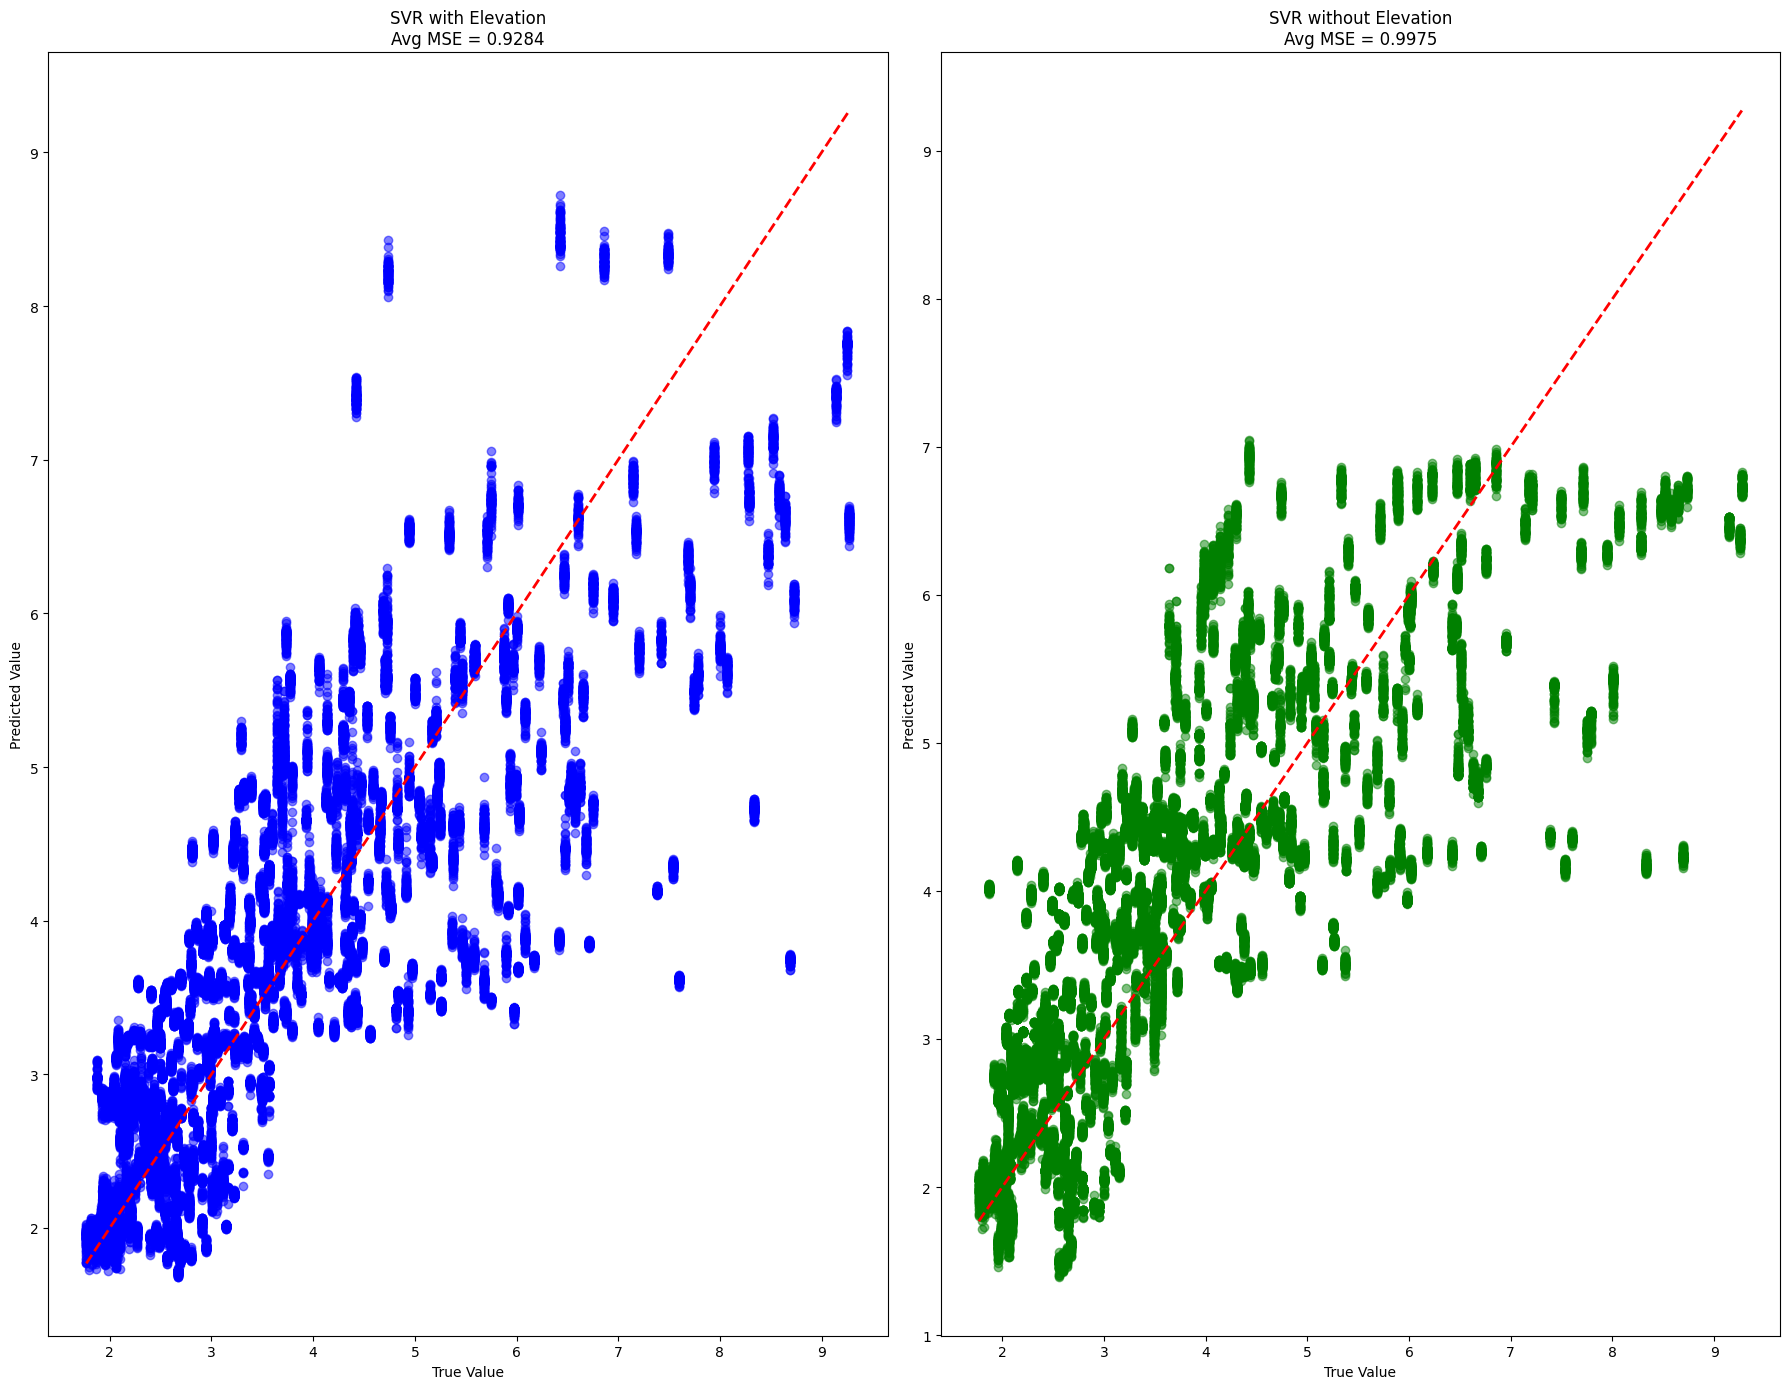

In [5]:
import geopandas as gpd
from sklearn.preprocessing import MinMaxScaler
from sklearn.svm import SVR
from sklearn.metrics import mean_squared_error
import matplotlib.pyplot as plt
import numpy as np
from tqdm import tqdm

plt.figure(figsize=(10,8))

# Load your shapefile into a GeoDataFrame
gdf = gpd.read_file('UK_PPT_DEM_12km.shp')

# Extract features and target variable
features = gdf[['latitude', 'longitude', 'average_de']]  # Features with elevation
target = gdf['value']

# Initialize scalers
feature_scaler = MinMaxScaler()
target_scaler = MinMaxScaler()

# Fit scalers and transform the data
scaled_features = feature_scaler.fit_transform(features)
scaled_target = target_scaler.fit_transform(target.to_numpy().reshape(-1, 1)).ravel()

# Append scaled columns to the original GeoDataFrame
gdf['norm_lat'] = scaled_features[:, 0]
gdf['norm_long'] = scaled_features[:, 1]
gdf['norm_elev'] = scaled_features[:, 2]
gdf['norm_val'] = scaled_target

# Separate coastal points
coastal_points = gdf[gdf['classifica'] == 'coastal']

# Number of runs and range for random state
num_runs = 1000
random_states = np.random.randint(0, 100000, num_runs)

# Initialize dictionaries to store results
mse_results_with_elev = []
mse_results_without_elev = []
all_test_with_elev = []
all_pred_with_elev = []
all_test_without_elev = []
all_pred_without_elev = []

# SVR with elevation
for random_state in tqdm(random_states, desc='SVR with Elevation', unit='run'):
    num_coastal_test = int(len(coastal_points) * 0.10)
    coastal_test_indices = coastal_points.sample(n=num_coastal_test, random_state=random_state).index
    test_data = gdf.loc[coastal_test_indices]
    training_data = gdf.drop(coastal_test_indices)
    
    X_train = training_data[['norm_lat', 'norm_long', 'norm_elev']].values
    y_train = training_data['norm_val'].values
    X_test = test_data[['norm_lat', 'norm_long', 'norm_elev']].values
    y_test = test_data['norm_val'].values

    svr = SVR(kernel='rbf')
    svr.fit(X_train, y_train)
    y_pred = svr.predict(X_test)
    
    y_test_orig = target_scaler.inverse_transform(y_test.reshape(-1, 1))
    y_pred_orig = target_scaler.inverse_transform(y_pred.reshape(-1, 1))
    
    all_test_with_elev.append(y_test_orig.ravel())
    all_pred_with_elev.append(y_pred_orig.ravel())
    
    mse_normalized = mean_squared_error(y_test, y_pred)
    mse_original = mean_squared_error(y_test_orig, y_pred_orig)
    
    mse_results_with_elev.append(mse_original)

# Flatten lists and convert to numpy arrays
all_test_with_elev = np.concatenate(all_test_with_elev)
all_pred_with_elev = np.concatenate(all_pred_with_elev)
avg_mse_with_elev = np.mean(mse_results_with_elev)

# SVR without elevation
for random_state in tqdm(random_states, desc='SVR without Elevation', unit='run'):
    num_coastal_test = int(len(coastal_points) * 0.10)
    coastal_test_indices = coastal_points.sample(n=num_coastal_test, random_state=random_state).index
    test_data = gdf.loc[coastal_test_indices]
    training_data = gdf.drop(coastal_test_indices)
    
    X_train = training_data[['norm_lat', 'norm_long']].values
    y_train = training_data['norm_val'].values
    X_test = test_data[['norm_lat', 'norm_long']].values
    y_test = test_data['norm_val'].values

    svr = SVR(kernel='rbf')
    svr.fit(X_train, y_train)
    y_pred = svr.predict(X_test)
    
    y_test_orig = target_scaler.inverse_transform(y_test.reshape(-1, 1))
    y_pred_orig = target_scaler.inverse_transform(y_pred.reshape(-1, 1))
    
    all_test_without_elev.append(y_test_orig.ravel())
    all_pred_without_elev.append(y_pred_orig.ravel())
    
    mse_normalized = mean_squared_error(y_test, y_pred)
    mse_original = mean_squared_error(y_test_orig, y_pred_orig)
    
    mse_results_without_elev.append(mse_original)

# Flatten lists and convert to numpy arrays
all_test_without_elev = np.concatenate(all_test_without_elev)
all_pred_without_elev = np.concatenate(all_pred_without_elev)
avg_mse_without_elev = np.mean(mse_results_without_elev)

# Plot True vs. Predicted for both cases
plt.subplot(1, 2, 1)
plt.scatter(all_test_with_elev, all_pred_with_elev, alpha=0.5, color='blue')
plt.plot([all_test_with_elev.min(), all_test_with_elev.max()], [all_test_with_elev.min(), all_test_with_elev.max()], 'r--', lw=2)  # Line for perfect fit
plt.xlabel('True Value')
plt.ylabel('Predicted Value')
plt.title(f'SVR with Elevation\nAvg MSE = {avg_mse_with_elev:.4f}')

plt.subplot(1, 2, 2)
plt.scatter(all_test_without_elev, all_pred_without_elev, alpha=0.5, color='green')
plt.plot([all_test_without_elev.min(), all_test_without_elev.max()], [all_test_without_elev.min(), all_test_without_elev.max()], 'r--', lw=2)  # Line for perfect fit
plt.xlabel('True Value')
plt.ylabel('Predicted Value')
plt.title(f'SVR without Elevation\nAvg MSE = {avg_mse_without_elev:.4f}')

plt.tight_layout()
plt.show()


### Non Scaled down version MSE (Only RBF Kernel)

rbf Kernel: 100%|██████████| 1000/1000 [02:34<00:00,  6.48it/s]


rbf Kernel:
Average MSE = 0.8908


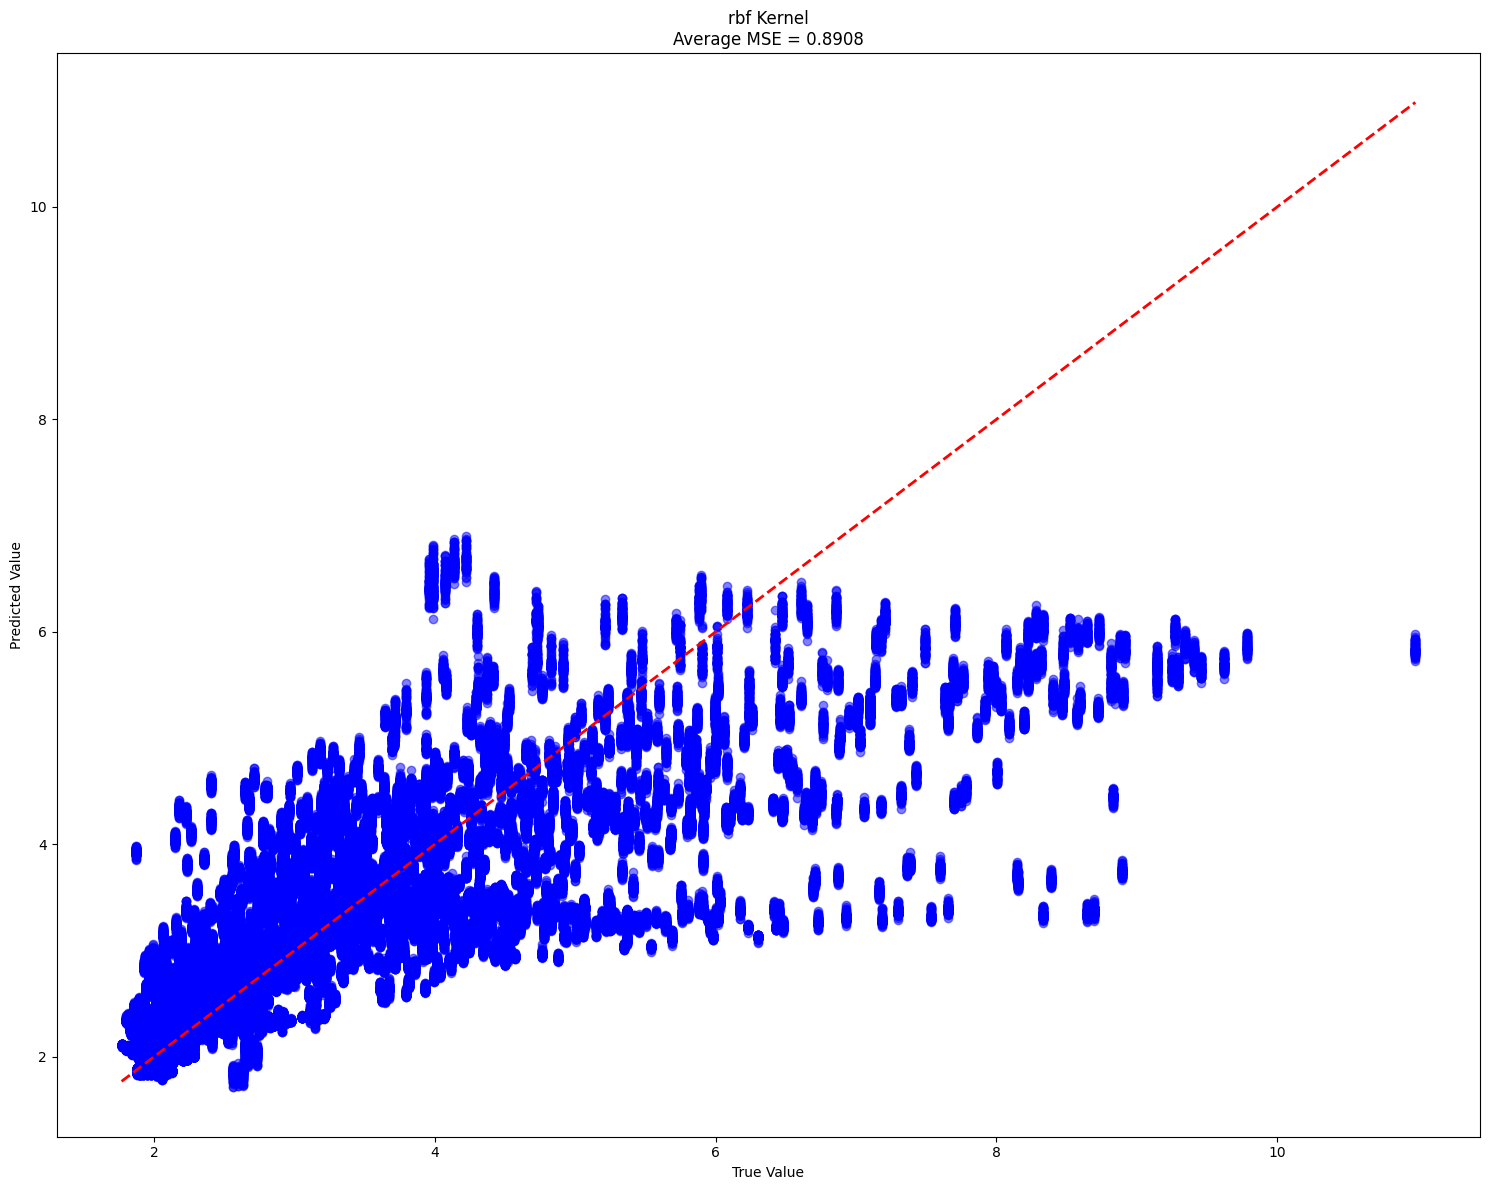

In [5]:
import geopandas as gpd
from sklearn.svm import SVR
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import numpy as np
from tqdm import tqdm  # Import tqdm for progress bars

# Load your shapefile into a GeoDataFrame
gdf = gpd.read_file('UK_PPT_DEM_12km.shp')

# Extract features and target variable
features = gdf[['latitude', 'longitude']]
target = gdf['value']

# Define kernels to test
kernels = ['rbf']

# Number of runs and range for random state
num_runs = 1000
random_states = np.random.randint(0, 100000, num_runs)

# Create a figure for plotting
plt.figure(figsize=(15, 12))

for i, kernel in enumerate(kernels):
    all_test = []
    all_pred = []
    kernel_mse = []
    
    # Progress bar for the random states
    for random_state in tqdm(random_states, desc=f'{kernel} Kernel'):
        # Split data into training and testing sets
        X_train, X_test, y_train, y_test = train_test_split(
            features, target, test_size=0.1, random_state=random_state
        )
        
        # Initialize SVR with the kernel
        svr = SVR(kernel=kernel)
       
        # Fit the model
        svr.fit(X_train, y_train)
      
        # Predict on test data
        y_pred = svr.predict(X_test)
        
        # Append to all_test and all_pred
        all_test.append(y_test.to_numpy())
        all_pred.append(y_pred)
        
        # Calculate performance
        mse = mean_squared_error(y_test, y_pred)  # MSE on original scale
        kernel_mse.append(mse)
    
    # Flatten lists and convert to numpy arrays
    all_test = np.concatenate(all_test)
    all_pred = np.concatenate(all_pred)
    
    # Average MSE over all runs
    avg_mse = np.mean(kernel_mse)
    
    # Print MSE
    print(f'{kernel} Kernel:')
    print(f'Average MSE = {avg_mse:.4f}')
    
    # Plot True vs. Predicted for all runs
    plt.subplot(1, len(kernels), i + 1)  # Adjust grid size based on number of kernels
    plt.scatter(all_test, all_pred, alpha=0.5, color='blue')
    plt.plot([all_test.min(), all_test.max()], [all_test.min(), all_test.max()], 'r--', lw=2)  # Line for perfect fit
    plt.xlabel('True Value')
    plt.ylabel('Predicted Value')
    plt.title(f'{kernel} Kernel\nAverage MSE = {avg_mse:.4f}')

plt.tight_layout()
plt.show()


### Support Vector Map 

C:\Users\vibhu\AppData\Local\Temp\ipykernel_1940\2105082674.py:46: UserWarning: You passed a edgecolor/edgecolors ('k') for an unfilled marker ('x').  Matplotlib is ignoring the edgecolor in favor of the facecolor.  This behavior may change in the future.
  plt.scatter(X_test[:, 1], X_test[:, 0], c=y_test, edgecolors='k', s=50, marker='x', label='Test Data')  # Swapped axes here


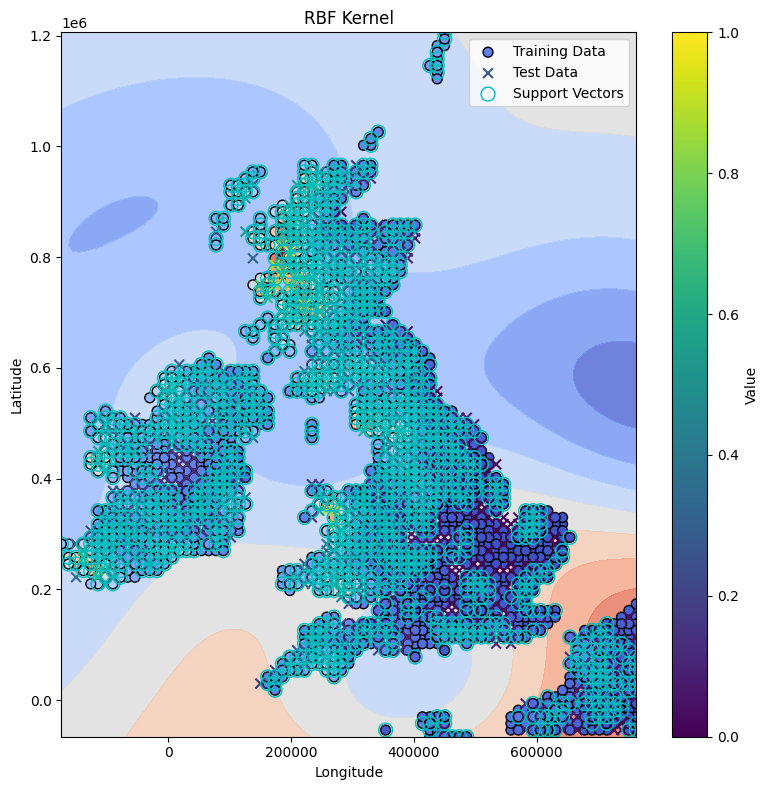

In [17]:
import geopandas as gpd
from sklearn.svm import SVR
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

# Load your shapefile into a GeoDataFrame
gdf = gpd.read_file('UK_PPT_DEM_12km.shp')

# Extract features and target variable
features = gdf[['latitude', 'longitude']].values
target = gdf['value'].values

# Split data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(features, target, test_size=0.2, random_state=42)

# Define kernels to test
kernels = ['rbf']
kernel_labels = ['RBF']
model_colors = ['c']

# Create a figure for plotting
plt.figure(figsize=(8, 8))

for i, kernel in enumerate(kernels):
    # Initialize SVR with the kernel
    svr = SVR(kernel=kernel)
    
    # Fit the model
    svr.fit(X_train, y_train)
    
    # Predict on the full range of input data
    X_range = np.linspace(features[:, 1].min(), features[:, 1].max(), 100)  # Swapped axes here
    y_range = np.linspace(features[:, 0].min(), features[:, 0].max(), 100)  # Swapped axes here
    
    # Create a grid for plotting predictions
    X_grid, Y_grid = np.meshgrid(X_range, y_range)
    Z_grid = svr.predict(np.c_[X_grid.ravel(), Y_grid.ravel()])
    Z_grid = Z_grid.reshape(X_grid.shape)
    
    # Plot the prediction surface
    plt.subplot(1, len(kernels), i + 1)
    plt.contourf(X_grid, Y_grid, Z_grid, alpha=0.8, cmap='coolwarm')
    plt.scatter(X_train[:, 1], X_train[:, 0], c=y_train, edgecolors='k', s=50, cmap='coolwarm', label='Training Data')  # Swapped axes here
    plt.scatter(X_test[:, 1], X_test[:, 0], c=y_test, edgecolors='k', s=50, marker='x', label='Test Data')  # Swapped axes here
    
    # Plot support vectors
    support_vectors = svr.support_vectors_
    plt.scatter(support_vectors[:, 1], support_vectors[:, 0], facecolor='none', edgecolor=model_colors[i], s=100, label='Support Vectors')  # Swapped axes here
    
    plt.xlabel('Longitude')  # Updated label
    plt.ylabel('Latitude')   # Updated label
    plt.title(f'{kernel_labels[i]} Kernel')
    plt.legend()
    plt.colorbar(label='Value')

plt.tight_layout()
plt.show()
